# Feed Forward Neural Network in pure Python

## Dependancies and supporting functions
Load all dependancies and supporting functions by running the code block below.

In [171]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.datasets import make_moons
from IPython.display import clear_output
from IPython import display
from time import sleep
from sklearn.metrics import precision_score, accuracy_score
from random import shuffle

def one_hot(Y):
    dimensions = len(np.unique(Y))
    oneHot = [np.zeros(dimensions) for y in Y]
    for i, y in enumerate(Y):
        oneHot[i][y] = 1
    return oneHot

def mesh_grid(X, step_size=0.08):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, step_size),
                         np.arange(y_min, y_max, step_size))
    
def prediction_contours(xx, yy):
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    return Z.reshape(xx.shape)

## Neural Networks 101

In this notebook we will go through how to develop a simple neural network from scratch in pure python. We thus build it without the convenience of linear algebra and use simple for loops instead. We do this to ensure everyone can get a feeling of what is going on under the hood, even if they still feel a bit unconfortable with linear algebra. 

The problem we are going to solve is the Two Moons problem. This problem is used because of it is simple yet cannot be properly solved with linear functions such as Logistic Regression. 

In order to solve it with a neural network we will go through:
* Selecting a non-linear activation function
* Implementing the forward propagation
* Implementing the backward propagation
* Training the network on the dataset

### Initializing variables
In order to create the neural network we need to be able to store the information. In order to define these variables we need to know the size of the network. In our extremely simplified neural network we need to know three things:
* The amount of features of the data we train on (2 in our case)
* The number of hidden units we want in our hidden layer
* The number of possible classes available in the dataset (2 in our case)

With this knowledge we can go about and define the variables we need. In order to make this network as simple as possible we will save a lot of information explicitly. However, the two most important parts in the following cell is the sizes of the weights and the lack of bias. 

You will always add a bias when you multiply a data feature with a weight during training. In the following notebooks this will be done explicitly. However, here we do it implicitly by adding a single neuron which we do not do anything with when training. This node will end up doing the same as a bias since all weights will be summed together. 

In [180]:
def initialize(input_dimensions, hidden_dimensions, output_dimensions, selu=False):
    input_nodes = input_dimensions + 1 # We add one to have room for bias node
    hidden_nodes = hidden_dimensions
    output_nodes = output_dimensions

    # Initilize arrays of 1s for activations 
    input_activations = np.ones(input_nodes)
    hidden_activations = np.ones(hidden_nodes)
    output_activations = np.ones(output_nodes)

    # Initialize randomized weights
    input_weights = np.random.randn(input_nodes, hidden_nodes)
    output_weights = np.random.randn(hidden_nodes, output_nodes)

    # Initialize a cache used to do store the last step size in backpropagation
    input_stepsize = np.zeros((input_nodes, hidden_nodes)) # Input x Hidden
    output_stepsize = np.zeros((hidden_nodes, output_nodes)) # Hidden x Output
    
    return (input_nodes, hidden_nodes, output_nodes, input_activations, hidden_activations, 
            output_activations, input_weights, output_weights, input_stepsize, output_stepsize)

### Choosing non-linearity

With the variables in place we need to choose a non-linearity for our activation function. Using a non-linear activation function is fundamental for deep learning. This is because all other parts of deep learning is simply mulitplying weights to the input which is a linear function. Without a non-liniear activation function any network regardless of its size or shape would thus only be able to represent linear functions.

Activation functions are still a hot research topic and new activation functions appear regularly. However, there are a few which have been proven to work over and over again. Of these Sigmoid and TanH are the most classical choices, and was the preffered activation functions for many years. 

Recently the trend is moving towards more minimalistic activation functions which generally only differ from linear functions when the input is less than zero. In theory any non-linear function can be used as long as its derivative can be computed efficiently. However, in practice the functions shown below tend to do very well, and one should have a really good reason to try and come up with a new activation function instead of just using one of the existing.

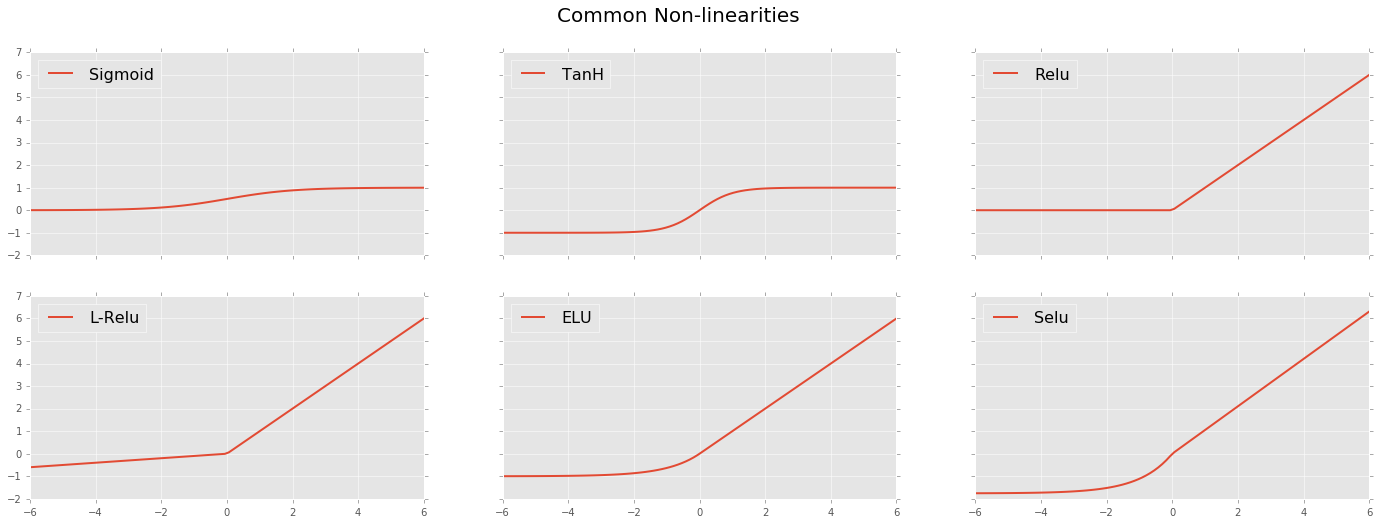

In [185]:
# Sigmoid Activation Function
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# TanH Activation Function
def tanh(x):
    return (1 - np.exp(-2*x)) / (1 + np.exp(-2*x))

# Relu Activation Function
def relu(x):
    return max(0., x)

# Leaky Relu Activation Function
def leaky_relu(x):
    return max(0., x) + 0.1 * min(0, x)

# Elu Activation function
# https://arxiv.org/pdf/1511.07289.pdf
def elu(x, alpha=1):
    return x if x >= 0 else alpha * (np.exp(x) - 1)

# Selu activation function
def selu(x, alpha=1.6732632423543772848170429916717, scale=1.0507009873554804934193349852946):
    return scale * x if x > 0 else scale * (alpha * np.exp(x) - alpha)
    
X = np.linspace(-6, 6, 100)
labels = ['Sigmoid',
          'TanH',
          'Relu',
          'L-Relu',
          'ELU',
          'Selu']
data = [[sigmoid(x) for x in X],
        [tanh(x) for x in X],
        [relu(x) for x in X],
        [leaky_relu(x) for x in X],
        [elu(x) for x in X],
        [selu(x) for x in X]]

rows = 2
columns = len(labels) / rows
fig, axn = plt.subplots(rows, columns, figsize=(8*columns,4*rows), sharey=True, sharex=True)
plt.suptitle('Common Non-linearities', fontsize=20)

for i, row in enumerate(axn):
    for j, ax in enumerate(row):
        index = i*columns+j
        ax.plot(X, data[index], label=labels[index], lw=2)
        ax.legend(loc=2, fontsize=16)

One of the reasons why the field moved away from Sigmoid and TanH is the dissapearing gradients when the absolute value of the weights increases. Its only in a small range centered around 0, that the gradient of the activation functions is big enough for efficient learning to occur. When the absolute value increases the gradient vanishes which influences the learning curve. 

With the newer functions which are linear for positive weights the gradient only vanishes with negative weights. This has been shown to have a positive effect on the convergence rate.

A general advice is thus to start out with the Relu activation function and then try the other functions if the performance does not live up to expectations. 

### Selu Activation
[Scaled exponential linear units](https://arxiv.org/pdf/1706.02515.pdf) is the newest activation function on the block from June 8, 2017. The aim is to add a self-normalizing property to the neural network in order to decrease variance and training errors. The Selu activation push neuron activations to zero mean and unit variance thereby leading to the same effect as batch normalization, which enables to robustly learn many layers.

#### Properties
* Negative and positive values to control the mean
* Derivatives approaching 0 to dampen variance
* Slope larger than 1 to increase variance
* Continuous curve

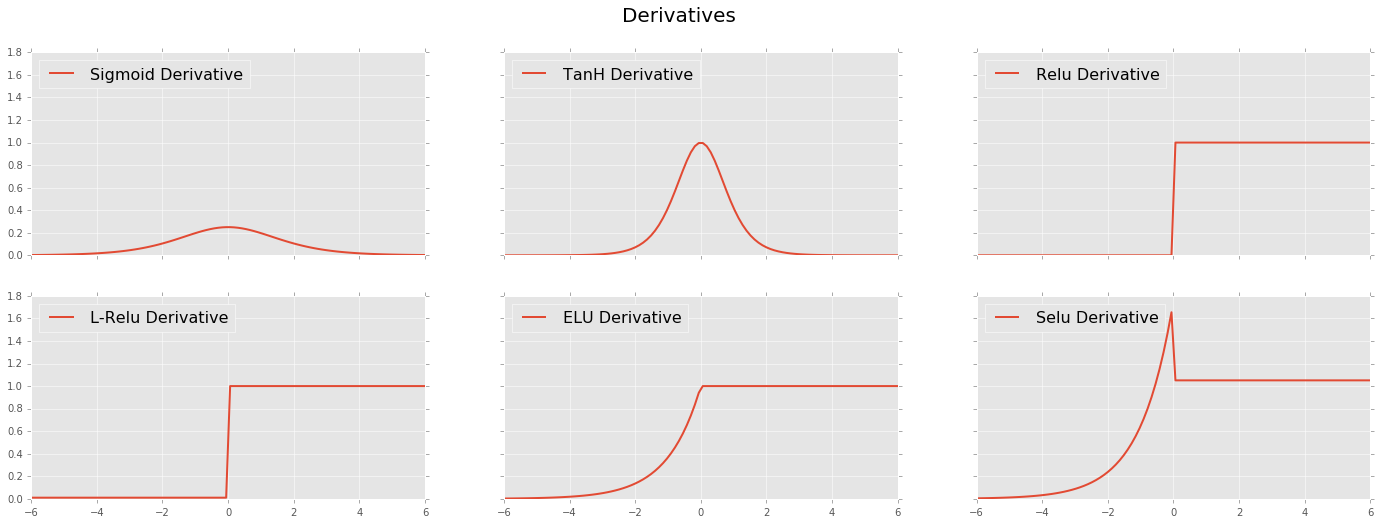

In [184]:
X = np.linspace(-6, 6, 100)

def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

def tanh_derivative(y):
    return 1 - np.square(tanh(y))

def relu_derivative(x):
    return 1. if x > 0. else 0.

def leaky_relu_derivative(x):
    return 1 if x >= 0 else 0.01

def elu_derivative(x, alpha=1):
    return 1 if x >= 0 else elu(x, alpha) + alpha

def selu_derivative(x, alpha=1.6732632423543772848170429916717, scale=1.0507009873554804934193349852946):
    return scale if x > 0 else scale * alpha * np.exp(x)

labels = ['Sigmoid Derivative',
          'TanH Derivative',
          'Relu Derivative',
          'L-Relu Derivative',
          'ELU Derivative',
          'Selu Derivative']
data = [[sigmoid_derivative(x) for x in X],
        [tanh_derivative(x) for x in X],
        [relu_derivative(x) for x in X],
        [leaky_relu_derivative(x) for x in X],
        [elu_derivative(x) for x in X],
        [selu_derivative(x) for x in X]]

rows = 2
columns = len(labels) / rows
fig, axn = plt.subplots(rows, columns, figsize=(8*columns,4*rows), sharey=True, sharex=True)
plt.suptitle('Derivatives', fontsize=20)

for i, row in enumerate(axn):
    for j, ax in enumerate(row):
        index = i*columns+j
        ax.plot(X, data[index], label=labels[index], lw=2)
        ax.legend(loc=2, fontsize=16)

## Forward Propagation
With the variables initialized and the activation function chosen. We are ready to define the forward propagation function used to map the input to a prediction. 
The forward propagation is a relatively simple function. In each layer we multiply the input with the weights and add a bias (implicitly). The result of each of these linear operations we transform with our non-linear activation function. 

In the final layer the output can either be out through a linear function (typically used for regression) or through a non-linear function such as we do here (typically used for classification). For classification the most normal function to use is [Softmax](https://en.wikipedia.org/wiki/Softmax_function) which transforms the output into a propability distributions indicating the likelyhood of the input belonging to each class.

In [175]:
def forward_propagation(inputs):
    if len(inputs) != input_nodes - 1:
        raise ValueError("Wrong number of inputs ;) ({} instead of {})".format(len(inputs), input_nodes - 1))

    # Set activations to be equal to new inputs
    for i in range(input_nodes - 1): # we subtract one in order not to touch the bias
        input_activations[i] = inputs[i]

    # Calculate the weighted value for each hidden neuron
    # Remember that in FFNs each neuron is connected to all neurons in the previous layer
    for i in range(hidden_nodes):
        value = 0.0
        for j in range(input_nodes):
            value += input_activations[j] * input_weights[j][i]

        hidden_activations[i] = relu(value) # Apply the non-linear function to the weighted value

    # Calculate the weighted value for each output neuron
    # !! Notice: This is almost the same as the step before !!
    for i in range(output_nodes):
        value = 0.0
        for j in range(hidden_nodes):
            value += hidden_activations[j] * output_weights[j][i]

        # Apply the sigmoid function to convert each activation to a value between 0 and 1.
        # Normally softmax is used for this, but for now we are using this simpler (yet slightly incorrect)
        # approach
        output_activations[i] = sigmoid(value)

    return output_activations

## Backward Propagation
Backpropagation is one of the primary reasons why deep learning is computationally tractable. It is used to compute how much each weight contribute to the error of the network. This knowledge is used to figure out which weights to tune and how much. 

In [186]:
def backward_propagation(targets, learning_rate):
    if len(targets) != output_nodes:
        raise ValueError("Wrong number of targets ;) ({} instead of {})".format(len(targets), output_nodes))

    # Initialize deltas used to choose the direction the weights should change
    output_deltas = np.zeros(output_nodes)
    hidden_deltas = np.zeros(hidden_nodes)

    # Update the deltas for the output layer
    for i in range(output_nodes):
        error = -(targets[i] - output_activations[i])
        output_deltas[i] = sigmoid_derivative(output_activations[i]) * error

    # Update the deltas or the hidden layer
    for i in range(hidden_nodes):
        error = 0.0
        for j in range(output_nodes):
            error += output_deltas[j] * output_weights[i][j]

        hidden_deltas[i] = relu_derivative(hidden_activations[i]) * error

    # Update the weights connecting the hidden layer to the output layer
    for i in range(hidden_nodes):
        for j in range(output_nodes):
            change = output_deltas[j] * hidden_activations[i]
            output_weights[i][j] -= learning_rate * change + output_stepsize[i][j]
            output_stepsize[i][j] = change

    # Update the weights connecting the input layer to the hidden layer
    for i in range(input_nodes):
        for j in range(hidden_nodes):
            change = hidden_deltas[j] * input_activations[i]
            input_weights[i][j] -= learning_rate * change + input_stepsize[i][j]
            input_stepsize[i][j] = change

    # Calculate Mean Squared Error 
    error = sum((targets - output_activations) ** 2) / len(targets)

    return error

## Train and Prediction

With forward and backward propagation defined, the training the network is really simple. One simply iterates through each input and propagate it through the network with forward propagation. From here we calculate the error, and run back propagation to update the weights accordingly. 

The procedure for making predictions with the network is then just a single forward propagation through the network. (We then run an argmax on the one-hot vector to convert it back into the original classes defined by an integer)

In [187]:
def train(patterns, epochs, learning_rate):
    error_per_epoch = []
    for i in range(epochs):
        error = 0.0

        for p in patterns:
            inputs, targets = p

            forward_propagation(inputs)
            error += backward_propagation(targets, learning_rate)
            
        error_per_epoch.append(error) 
    
    return error_per_epoch

def predict(X):
    predictions = []

    for x in X:
        pred = forward_propagation(x)
        pred = np.argmax(pred)
        predictions.append(pred)
    return np.array(predictions)

In [188]:
def train_with_animation(train_data, test_data, epochs = 10, learning_rate = 0.002, plot_step=2):
    num_frames = epochs

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
    ax1.set_title("Train Targets")
    
    X_train, Y_train_orig = zip(*train_data)
    Y_train = [np.argmax(l) for l in Y_train_orig]
    X_train = np.array(X_train)

    # create a mesh to plot in
    xx_train, yy_train = mesh_grid(X_train)

    
    ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, cmap=plt.cm.coolwarm)
    
    X_test, Y_test_orig = zip(*test_data)
    Y_test = [np.argmax(l) for l in Y_test_orig]
    X_test = np.array(X_test)
    
    # create a mesh to plot in
    xx_test, yy_test = mesh_grid(X_test)
    
    test_scat = ax2.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=60, cmap=plt.cm.coolwarm)

    cost = []
    for i in range(1, epochs + 1):
        error = 0.0
        
        for p in train_data:
            inputs, targets = p
            
            forward_propagation(inputs)
            error += backward_propagation(targets, learning_rate)
        
        plt.suptitle("Epoch: {}".format(i), fontsize=14, fontweight='bold')
        cost.append(error)
        if i % plot_step == 0:
            ax1.cla()
            pred_train = predict(X_train)
            train_precision = precision_score(Y_train, pred_train)
            train_accuracy = accuracy_score(Y_train, pred_train)
            ax1.set_title("Train Precision: {0:0.2f}, Train Accuracy: {1:0.2f}".format(train_precision, train_accuracy))
            ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, c=Y_train, cmap=plt.cm.coolwarm)
            ax1.contourf(xx_train, yy_train, prediction_contours(xx_train, yy_train), cmap=plt.cm.coolwarm, alpha=0.3)

            ax2.cla()
            pred_test = predict(X_test)
            test_precision = precision_score(Y_test, pred_test)
            test_accuracy = accuracy_score(Y_test, pred_test)
            ax2.set_title("Test Precision: {0:0.2f}, Test Accuracy: {1:0.2f}".format(test_precision, test_accuracy))
            ax2.scatter(X_test[:, 0], X_test[:, 1], s=60, c=Y_test, cmap=plt.cm.coolwarm)
            ax2.contourf(xx_test, yy_test, prediction_contours(xx_test, yy_test), cmap=plt.cm.coolwarm, alpha=0.3)


            ax3.cla()
            ax3.set_title("Mean Squared Error: {0:0.2f}".format(error))
            ax3.plot(cost, label="Training Cost")
            ax3.legend()

            display.clear_output(wait=True)
            display.display(plt.gcf())    

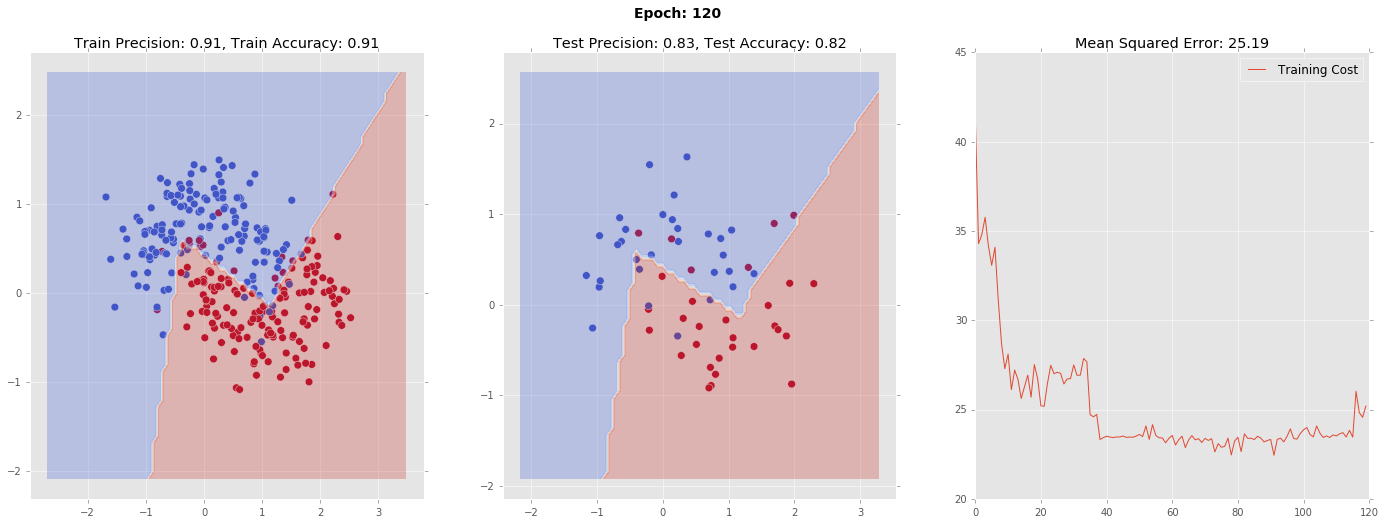

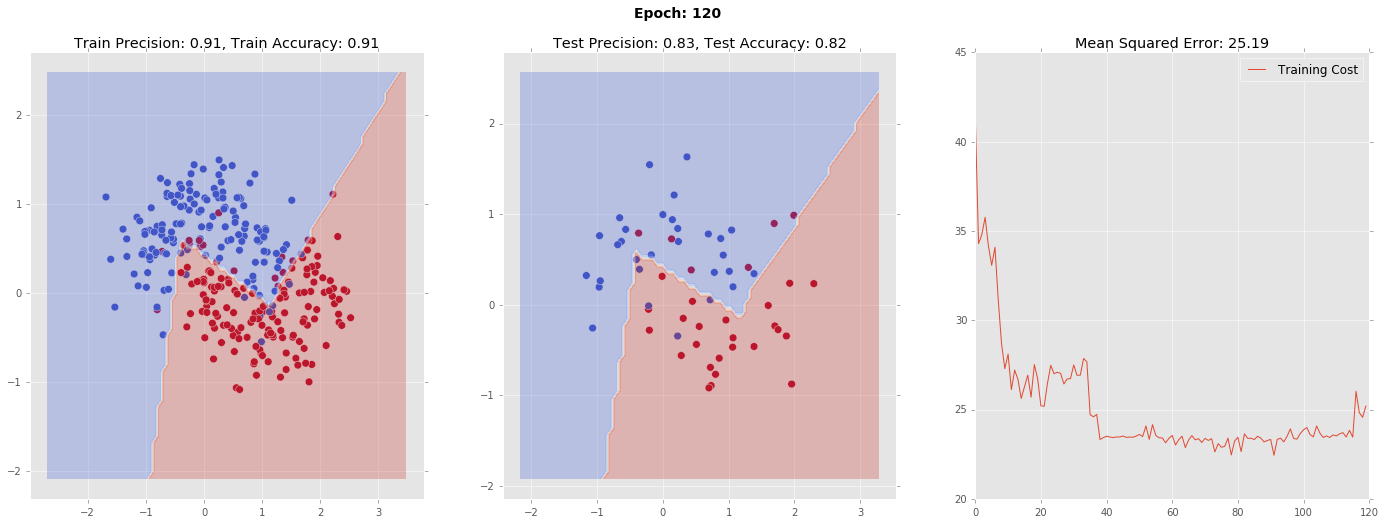

In [189]:
np.random.seed(0)

input_dimensions = 2
hidden_dimensions = 10
output_dimensions = 2


train_size = 300
test_size = 60
noise = 0.30

epochs = 120
plot_steps = 5
learning_rate = 0.1

input_nodes, hidden_nodes, output_nodes,\
input_activations, hidden_activations, output_activations,\
input_weights, output_weights,\
input_stepsize, output_stepsize = initialize(input_dimensions, hidden_dimensions, output_dimensions)

X_train, Y_train = make_moons(train_size, noise=noise)
X_test, Y_test = make_moons(test_size, noise=noise)

train_data = list(zip(X_train, one_hot(Y_train)))
test_data = list(zip(X_test, one_hot(Y_test)))

train_with_animation(train_data, test_data, epochs=epochs, learning_rate=learning_rate, plot_step=plot_steps)

## <span style="color:red"> Exercise 1.1: Investigate the Non-Linearities</span>
* Try the various activation functions and see how the network behaves
    * Which activation function achieves the lowest training cost?
    * Which activation function seems most stable?